# 훈련이 되어있는 컨브넷 사용하기

이미지 데이터셋이 적을 경우 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 사전 훈련된 네트워크는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다. 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다. 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용합니다. 예를 들어 (대부분 동물이나 생활 용품으로 이루어진) ImageNet 데이터셋에 네트워크를 훈련합니다. 그다음 이 네트워크를 이미지에서 가구 아이템을 식별하는 것 같은 다른 용도로 사용할 수 있습니다. 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다. 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있습니다.

여기에서는 (1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용해보겠습니다. ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있습니다. 그래서 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 것 같습니다.

우리는 이번에 VGG16 알고리즘을 사용하겠습니다. 간단하며 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. 조금은 오래되었고 최고 수준 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁습니다. 하지만 이 모델의 구조가 이전에 보았던 것과 비슷해서 새로운 개념을 도입하지 않고 이해하기 쉽기 때문에 선택했습니다.

사전 훈련된 네트워크를 사용하는 것에는 두 가지 방법이 있습니다. <font color=skyblue>__특성 추출과 미세 조정__</font>입니다. 이 두 가지를 모두 다루어 보겠습니다. 먼저 특성 추출부터 살펴봅니다.

# 특성 추출

특성 추출은 사전에 학습된 네트워크의 표현을 사용해 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다. 앞서 보았듯이 컨브넷은 이미지 분류를 위해 두 부분으로 구성됩니다. 먼저 연속된 합성곱과 풀링 층으로 시작해서 완전 연결 분류기로 끝납니다. 첫 번째 부분을 모델의 합성곱 기반층(convolutional base)이라고 부르겠습니다. 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반층을 선택해 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련합니다. 

합성곱 층만 재사용하는 이유는 무엇일까요? 완전 연결 분류기도 재사용할 수 있을까요? 일반적으로 권장하지 않습니다. 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용 가능하기 때문입니다. 컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다. 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만을 담고 있습니다. 더군다나 완전 연결 층에서 찾은 표현은 더이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않습니다. 완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체의 위치를 고려합니다. 객체의 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없습니다.

특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성)의 수준은 모델에 있는 층의 깊이에 달려 있습니다. 모델의 하위 층은 (에지, 색깔, 질감 등과 같이) 지역적이고 매우 일반적인 특성 맵을 추출합니다. 반면 상위 층은 ('강아지 눈'이나 '고양이 귀'와 같이) 좀 더 추상적인 개념을 추출합니다. 만약 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋습니다. 

ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있습니다. 이런 경우 원본 모델의 완전 연결 층에 있는 정보를 재사용하는 것이 도움이 될 것 같습니다. 하지만 새로운 문제의 클래스가 원본 모델의 클래스 집합과 겹치지 않는 좀 더 일반적인 경우를 다루기 위해서 여기서는 완전 연결 층을 사용하지 않겠습니다.

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해보겠습니다. 그런 다음 이 특성으로 강아지 vs. 고양이 분류기를 훈련합니다.

VGG16 모델은 케라스에 패키지로 포함되어 있습니다. keras.applications 모듈에서 임포트할 수 있습니다. 해당 모듈에서 사용 가능한 모델들은 다음과 같습니다.

- Xception
- InceptionV3
- ResNet50
- VGG16
- VGG19
- MobileNet

모델을 만들어보겠습니다.

In [1]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 433s 7us/step


VGG16 함수에 세 개의 매개변수를 전달합니다.
- weights : 모델을 초기화할 가중치 체크포인트를 지정
- include_top : 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 설정. 기본값은 포함(True). 이번 실습은 좀 더 일반적인 경우에 이미지 분류기가 잘 작동할지를 보기 위한 목적이므로 포함시키지 않음.
- input_shape : 네트워크에 주입할 이미지 텐서의 크기

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

이전 실습에서 진행한 컨브넷보다 층이 많아졌지만 구조는 유사합니다. 이 네트워크의 최종 특성 맵의 크기는 (4, 4, 512)입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다. 이 지점에서 두 가지 방식이 가능합니다.

- 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그다음 이 데이터를 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 무거운 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.
- 준비한 모델 위에 Dense층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.

두 가지 방식을 모두 다루어 보겠습니다. 첫 번째 방식을 구현하는 방법은 conv_base에 데이터를 주입하고 출력을 기록합니다. 이 출력을 새로운 모델의 입력으로 사용합니다.

ImageDataGenerator를 사용해 이미지와 레이블을 넘파이 배열로 추출하겠습니다. conv_base 모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출합니다.

## 훈련된 네트워크에 데이터를 주입하여 출력을 기록 후, 출력을 새로운 네트워크의 입력으로 사용하는 방법

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/user/Desktop/MLDL 학습용 데이터셋/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다.

In [4]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

그 후 완전 연결 분류기를 정의하고(규제를 위해 드롭아웃을 사용합니다) 저장된 데이터와 레이블을 사용해 훈련합니다.

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.rmsprop_v2.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
100/100 [==============================] - 2s 15ms/step - loss: 0.5693 - acc: 0.7100 - val_loss: 0.4463 - val_acc: 0.7980
Epoch 2/30
100/100 [==============================] - 1s 14ms/step - loss: 0.4231 - acc: 0.8025 - val_loss: 0.3565 - val_acc: 0.8720
Epoch 3/30
100/100 [==============================] - 2s 15ms/step - loss: 0.3546 - acc: 0.8460 - val_loss: 0.3231 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 1s 15ms/step - loss: 0.3118 - acc: 0.8660 - val_loss: 0.2969 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 1s 15ms/step - loss: 0.2808 - acc: 0.8910 - val_loss: 0.2826 - val_acc: 0.8840
Epoch 6/30
100/100 [==============================] - 1s 15ms/step - loss: 0.2557 - acc: 0.8935 - val_loss: 0.2719 - val_acc: 0.8860
Epoch 7/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2441 - acc: 0.9015 - val_loss: 0.2629 - val_acc: 0.8960
Epoch 8/30
100/100 [==============================] - 1s 15ms/step - 

두 개의 Dense층만 처리하면 되기 때문에 훈련이 매우 빠릅니다.

훈련 결과를 시각화하여 살펴보겠습니다.

In [6]:
import matplotlib.pyplot as plt

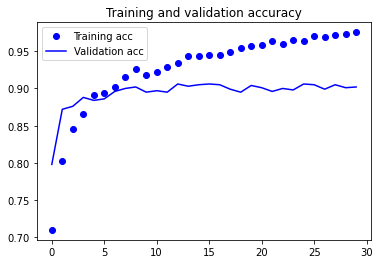

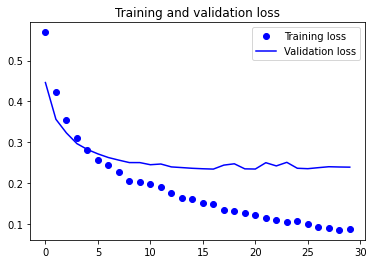

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 이전 절에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋습니다. 하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있음을 보여줍니다. 작은 이미지 데이터셋을 훈련하는 모델의 과대적합을 막는 데에 필수적인 데이터 증식을 사용하지 않았기 때문입니다. 

## 훈련된 네트워크에 완전 연결 층(Dense)을 추가하여 모델링하기
이제 특성 추출을 위해 두 번째로 언급한 방법을 살펴보겠습니다. 이 방법은 이미지 증식 기법을 적용할 수 있습니다. 또 GPU 사용이 강력히 권장됩니다.

이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. conv_base 모델을 확장하고 입력 데이터를 사용해 엔드 투 엔드로 실행합니다.

이 기법은 연산 비용이 크기 때문에 GPU 환경에서 시도하는 것을 권장합니다. GPU를 사용할 수 없다면 첫 번째 방법을 사용하세요.

모델은 층과 동일하게 작동하므로 층을 추가하듯이 Sequential 모델에 다른 모델(우리가 이미 구성한 conv_base)을 추가할 수 있습니다.

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

이 모델의 구조는 다음과 같습니다.

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


위에서 볼 수 있듯이 VGG16 합성곱 기반층은 14,174,688개의 매우 많은 파라미터를 가지고 있습니다. 합성곱 기반층 위에 추가한 분류기는 2백 만개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 Dense층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 trainable 속성을 False로 설정하여 네트워크를 동결할 수 있습니다.

In [10]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [11]:
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


이렇게 역전파되는 가중치에 대한 훈련을 하지 않게끔 설정을 하면 추가한 두 개의 Dense층의 가중치만 훈련될 것입니다. 층마다 두 개씩(가중치 행렬과 편향 벡터) 총 네 개의 텐서가 훈련됩니다. 컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 합니다. 그렇지 않으면 변경 사항이 적용되지 않습니다.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


C:\Users\user\AppData\Local\Temp\ipykernel_2592\3169746344.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 134s - loss: 0.5451 - acc: 0.7425 - val_loss: 0.4291 - val_acc: 0.8350 - 134s/epoch - 1s/step
Epoch 2/30
100/100 - 138s - loss: 0.4115 - acc: 0.8245 - val_loss: 0.3473 - val_acc: 0.8760 - 138s/epoch - 1s/step
Epoch 3/30
100/100 - 138s - loss: 0.3676 - acc: 0.8500 - val_loss: 0.3126 - val_acc: 0.8810 - 138s/epoch - 1s/step
Epoch 4/30
100/100 - 137s - loss: 0.3260 - acc: 0.8695 - val_loss: 0.2895 - val_acc: 0.8910 - 137s/epoch - 1s/step
Epoch 5/30
100/100 - 138s - loss: 0.3103 - acc: 0.8715 - val_loss: 0.2744 - val_acc: 0.8950 - 138s/epoch - 1s/step
Epoch 6/30
100/100 - 138s - loss: 0.2886 - acc: 0.8845 - val_loss: 0.2630 - val_acc: 0.8910 - 138s/epoch - 1s/step
Epoch 7/30
100/100 - 138s - loss: 0.2763 - acc: 0.8845 - val_loss: 0.2661 - val_acc: 0.9010 - 138s/epoch - 1s/step
Epoch 8/30
100/100 - 137s - loss: 0.2699 - acc: 0.8970 - val_loss: 0.2542 - val_acc: 0.9070 - 137s/epoch - 1s/step
Epoch 9/30
100/100 - 138s - loss: 0.2651 - acc: 0.8865 - val_loss: 0.2458 - val_acc: 0.8990

In [15]:
model.save('cats_and_dogs_small_3.h5')

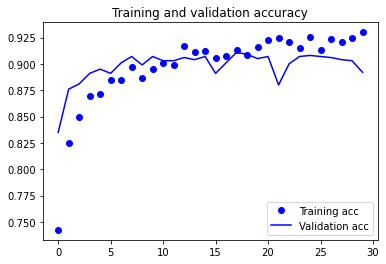

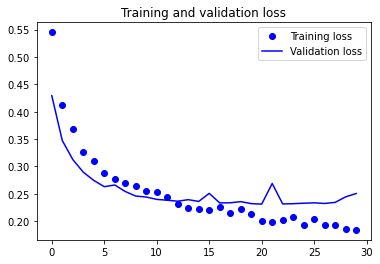

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

결과 그래프를 보면 알 수 있듯이 검증 정확도는 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었습니다.

# 미세 조정

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

앞서 랜덤하게 초기화된 상단 분류기를 훈련하기 위해 VGG16의 합성곱 기반층을 동결해야 한다고 말했습니다. 같은 이유로 맨 위에 있는 분류기가 훈련된 후에 합성곱 기반의 상위 층을 미세 조정할 수 있습니다. 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파됩니다. 이는 미세 조정될 층들이 사전에 학습한 표현들을 망가뜨리게 될 것입니다. 네트워크를 미세 조정하는 단계는 다음과 같습니다. 

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
2. 기반 네트워크를 동결합니다.
3. 새로 추가한 네트워크를 훈련합니다.
4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

처음 세 단계는 특성 추출을 할 때 이미 했던 것들입니다. 네 번째 단계를 진행해보겠습니다. conv_base의 동결을 해제하고 개별 층을 동결하겠습니다. 기반층의 구조를 다시 한 번 확인해보겠습니다.

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

여기서 마지막 세 개의 합성곱층에 대해서 미세 조정을 진행하겠습니다. 다시 말해, block4_pool까지 모든 층은 동결시키고 block_5_conv1-2-3층은 학습 대상입니다.

왜 더 많은 층에 대해서 미세 조정을 하지 않는지 궁금할 수 있습니다. 여기서 다음과 같은 고려사항을 주목해야합니다.

- 합성곱 기반층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면 상위 층은 좀 더 특화된 특성을 인코딩합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 나중에 쌓아올려진 층들에 대해(출력층에 가까운 층) 미세 조정을 수행하는 것입니다. 하위 층으로 갈수록 이미 재사용이 어느 정도 가능한 특성 맵으로 이루어지기 때문입니다.
- 훈련해야 할 파라미터가 많을수록 과대적합의 위험이 커집니다. 합성곱 기반층은 1천 5백만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.

미세 조정을 위해 마지막 컨브넷 층의 동결을 해제하겠습니다.

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if 'block5_conv' in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

이제 네트워크의 미세 조정을 시작하겠습니다. 학습률을 낮춘 RMSProp 옵티마이저를 사용합니다. Learning-Rate를 낮추는 이유는 미세 조정하는 세 개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.

진행해보겠습니다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

---
# 정리
훈련이 너무 오래 걸리는 관계로 이후 과정은 생략,
결과는 약 92% 정확도를 얻을 수 있을 것.

적은 데이터셋을 가지고 시도해볼 수 있는 것은?
1. 처음부터 훈련시키는 경우
   1. 데이터 증식
   2. 네트워크 조정
   3. 가중치 규제
   4. 드롭아웃


2. 훈련된 네트워크를 재사용하는 경우
   1. 특성 추출
      1. 훈련된 네트워크에 대한 학습 결과를 배열로 추출하여 새로운 네트워크에 훈련하기
         - Dense층만을 거치므로 훈련이 빠르다는 장점이 있음.
         - 과대적합 가능성 높음.
      2. 훈련된 네트워크에 층을 추가하여 훈련하기
         - 층이 더 쌓이므로 훈련이 굉장히 느려짐. ( GPU 권장 )
         - 데이터를 학습시키기 전에 기존 층은 동결시켜야함.
         - 증식된 데이터를 훈련하여 과대적합을 방지할 수 있음.
   2. 미세 조정
      1. 출력층에 가까운 층 몇 개에 대해서 미세 조정 진행
         (하위 층은 동결)
         - 출력층에 가까울수록 추상적인 특성(일반적이지 않은)을 훈련하는데, 이 부분을 일반화하기 위함
